In [66]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

import xgboost as xgb

%matplotlib inline

## a regression model for predicting housing prices (column 'median_house_value').

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-22 17:51:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  3.46MB/s    in 0.4s    

2023-10-22 17:51:20 (3.46 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [4]:
!head housing.csv

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY
-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


# Data preparation 

In [39]:
df = pd.read_csv('housing.csv')

print (df.head())

# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND' 
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Fill missing values with zeros.
#df = df.fillna(0)

# Apply the log transform to median_house_value
df['median_house_value'] = np.log1p(df['median_house_value'])

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [40]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# we will predict whether a customer is going to default (not being able to pay a loan)
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [41]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-120.25,37.93,13.0,493.0,76.0,196.0,68.0,3.3750,INLAND
1,-118.40,34.00,10.0,1526.0,339.0,705.0,268.0,5.8083,<1H OCEAN
2,-121.67,38.85,46.0,645.0,131.0,410.0,122.0,1.7417,INLAND
3,-118.14,33.88,24.0,3305.0,982.0,2085.0,881.0,2.6641,<1H OCEAN
4,-118.11,33.92,34.0,1414.0,263.0,983.0,264.0,4.1767,<1H OCEAN


In [42]:
y_train

array([11.80634853, 12.68168862, 11.61187447, ..., 11.46374572,
       11.93032573, 10.92054627])

# Question 1: ocean_proximity

decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?

In [43]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



# Question 2: 0.245

Train a random forest model with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)
* What's the RMSE of this model on validation?

In [49]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
print('train:', mean_squared_error(y_train, y_pred, squared=False))

y_pred = rf.predict(X_val)
print('val:', mean_squared_error(y_val, y_pred, squared=False))

train: 0.09867571708476802
val: 0.244910835217013


# Question 3: 160

Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.
* After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

In [51]:
for n_estimators in range(10, 210, 10):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print('N estimators is %s' % n_estimators, 'RMSE is', np.round(mean_squared_error(y_val, y_pred, squared=False), 3))

N estimators is 10 RMSE is 0.245
N estimators is 20 RMSE is 0.238
N estimators is 30 RMSE is 0.236
N estimators is 40 RMSE is 0.235
N estimators is 50 RMSE is 0.234
N estimators is 60 RMSE is 0.234
N estimators is 70 RMSE is 0.234
N estimators is 80 RMSE is 0.234
N estimators is 90 RMSE is 0.234
N estimators is 100 RMSE is 0.234
N estimators is 110 RMSE is 0.234
N estimators is 120 RMSE is 0.234
N estimators is 130 RMSE is 0.234
N estimators is 140 RMSE is 0.234
N estimators is 150 RMSE is 0.233
N estimators is 160 RMSE is 0.233
N estimators is 170 RMSE is 0.233
N estimators is 180 RMSE is 0.234
N estimators is 190 RMSE is 0.234
N estimators is 200 RMSE is 0.234


# Question 4: 25

Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
*  calculate the mean RMSE
*  Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [54]:
li = []

for max_depth in [10, 15, 20, 25]:
    for n_estimators in range(10, 210, 10):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        li.append([max_depth, n_estimators, rmse])
        #print('N estimators is %s' % n_estimators, 'max depth is %s' % max_depth,'RMSE is', np.round(mean_squared_error(y_val, y_pred, squared=False), 3))

In [56]:
rmse_df = pd.DataFrame(li, columns = ['max_depth', 'n_estimators', 'rmse'])

In [57]:
rmse_df.groupby(by='max_depth')['rmse'].mean()

max_depth
10    0.245462
15    0.235763
20    0.235005
25    0.234691
Name: rmse, dtype: float64

# Question 5:total_bedrooms

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
* n_estimators=10,
* max_depth=20,
* random_state=1,
* n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature (among these 4)?
* total_rooms
* median_income
* total_bedrooms
* longitude

In [ ]:
#  "gain" - the reduction in impurity before and after the split: in feature_importances_ field

In [65]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
        
rf.fit(X_train, y_train)
        
dict(zip(df_train.columns, rf.feature_importances_ ))

# total_rooms': 0.08603838292900823,
# 'median_income': 0.028272427270634358,
# 'total_bedrooms': 0.3355403365620536,
# 'longitude': 0.014464729672647775,

{'longitude': 0.014464729672647775,
 'latitude': 0.03001847738030148,
 'housing_median_age': 0.10249128069337625,
 'total_rooms': 0.08603838292900823,
 'total_bedrooms': 0.3355403365620536,
 'population': 0.2188198543307832,
 'households': 0.14745955406828115,
 'median_income': 0.028272427270634358,
 'ocean_proximity': 0.015736633318908736}

# Question 6: 0.3

In [ ]:
# 0.23234, eta 0.1
# 0.22897, eta 0.3

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

In [68]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

In [74]:
features = ['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity_less_1h_OCEAN',
       'ocean_proximity_INLAND', 'population', 'total_bedrooms',
       'total_rooms']

# DMatrix = specific structure for faster training with Xgboost 
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


In [75]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [76]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [78]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)


In [79]:
s = output.stdout

In [84]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_score', 'val_score']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [85]:
df_score = parse_xgb_output(output)

In [86]:
df_score[0:5]

,num_iter,train_score,val_score
0,0,8.07362,8.07348
1,5,1.38983,1.38852
2,10,0.33195,0.34802
3,15,0.22197,0.25614
4,20,0.20036,0.24508


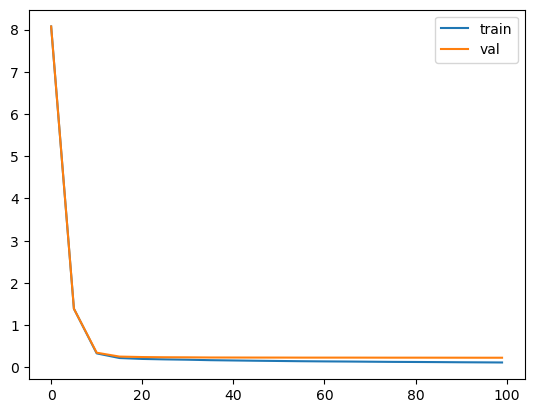

In [87]:
plt.plot(df_score.num_iter, df_score.train_score, label='train')
plt.plot(df_score.num_iter, df_score.val_score, label='val')
plt.legend()

In [88]:
df_score # val score is 0.22897

,num_iter,train_score,val_score
0,0,8.07362,8.07348
1,5,1.38983,1.38852
2,10,0.33195,0.34802
3,15,0.22197,0.25614
4,20,0.20036,0.24508
5,25,0.18991,0.24021
6,30,0.18204,0.23833
7,35,0.17091,0.23452
8,40,0.16422,0.23379
9,45,0.15756,0.23302


In [89]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [90]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [91]:
%%capture output

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
s = output.stdout

In [93]:
df_score = parse_xgb_output(output)
df_score # 0.23234, eta 0.1

,num_iter,train_score,val_score
0,0,10.37456,10.37545
1,5,6.13433,6.13236
2,10,3.63299,3.62939
3,15,2.15901,2.15616
4,20,1.29412,1.29329
5,25,0.78993,0.79342
6,30,0.50217,0.51149
7,35,0.34590,0.36371
8,40,0.26743,0.29345
9,45,0.23014,0.26315
